In [23]:
import sys
sys.path.append('../')
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pickle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import permutations
import random
import time
import os

from utils.metrics import RMSE
import utils.metrics as metrics
from simulators.ricker import ricker

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings('ignore')

In [3]:
# you can pre-generate the data using generate_data.py
x = torch.tensor(np.load("../data/ricker_x_4000.npy")).reshape(4000, 100, 100).to(device)

theta = np.load("../data/ricker_theta_4000.npy")

dataloader = DataLoader(x[:1000], batch_size=200, shuffle=True)

In [4]:
def regression_ABC(s_obs, param, sumStats, p):
    def mad(data):
        return np.mean(np.abs(data - np.mean(data, axis=0)), axis=0)

    if param.shape[0] < param.shape[1]:
        param = np.transpose(param)

    if sumStats.shape[0] < sumStats.shape[1]:
        sumStats = np.transpose(sumStats)
    
    M = len(param)
    M_epsilon = int(M*p)
    sumStats = sumStats
    s_obs = s_obs

    norm_factor = mad(sumStats)

    norm_sumStats = sumStats / norm_factor
    norm_s_obs = s_obs / norm_factor

    distance = np.linalg.norm(norm_sumStats - norm_s_obs, axis = 1)
    max_accepted_distance = np.sort(distance)[M_epsilon - 1]

    posterior_samples = param[distance <= max_accepted_distance, :]
    norm_sumStats_star = norm_sumStats[distance <= max_accepted_distance, :]

    weights = 1 - (distance[distance <= max_accepted_distance] / max_accepted_distance)**2
    W = np.diag(weights)

    s_obs_norm = np.tile(norm_s_obs, (M_epsilon,1))
    X = np.column_stack((np.ones(shape = (M_epsilon,1)), norm_sumStats_star - s_obs_norm))

    A = np.matmul(X.T, W)

    solution = np.linalg.solve(np.matmul(A, X), np.matmul(A, posterior_samples))

    beta = solution[1:,:]

    posterior_samples_adjusted = posterior_samples - np.matmul((norm_sumStats_star - s_obs_norm), beta)

    return posterior_samples_adjusted
    

In [5]:
class RickerSummary(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(RickerSummary, self).__init__()

        self.hidden_dim = hidden_dim
        self.input_size = input_size
        
        self.encoder = nn.Sequential(nn.Conv1d(self.input_size, 4, 3, 4),
                                     nn.Conv1d(4, 4, 3, 4),
                                     nn.Conv1d(4, 4, 3, 4),
                                     )
        
        self.decoder = nn.Sequential(nn.ConvTranspose1d(4, 4, 3, 4),
                                     nn.ConvTranspose1d(4, 4, 3, 4),
                                     nn.ConvTranspose1d(4, self.input_size, 3, 4),
                                     nn.Upsample(100)
                                     )

    def forward(self, Y):
        embeddings = self.encoder(Y.reshape(-1, 1, 100))
        output = self.decoder(embeddings.reshape(-1, 4, 1)).reshape(-1, 100, 100)
        return output
    
    def forward_encoder(self, Y):
        embeddings = self.encoder(Y.reshape(-1, 1, 100)).reshape(-1, 100, 4)
        return embeddings

# ABC

In [6]:
def solve_normal():
    summary_net_normal = RickerSummary(1, 4).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(summary_net_normal.parameters(), lr=0.01)

    # Train the model for some number of epochs
    num_epochs = 10
    time_list = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for data in dataloader:
            start_time = time.time()
            inputs = data
            optimizer.zero_grad()

            outputs = summary_net_normal(inputs)
            loss = criterion(outputs, inputs) / 10000

            loss.backward()
            optimizer.step()
            end_time = time.time()
            print(f"calculation time: {end_time - start_time}")
            time_list.append(end_time - start_time)
            if len(time_list) == 20:
                a = np.array(time_list)
                print(f"average: {np.mean(a)}({np.std(a)})")

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")
    return summary_net_normal

# ABC-RS

In [8]:
def solve_robust(beta, obs_cont):
    summary_net_robust = RickerSummary(1, 4).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(summary_net_robust.parameters(), lr=0.01)

    index_list = [int(i) for i in range(len(x))]

    num_epochs = 10
    time_list = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for data in dataloader:
            start_time = time.time()
            inputs = data
            optimizer.zero_grad()

            outputs = summary_net_robust(inputs)

            random.shuffle(index_list)
            context_embeddings = torch.mean(summary_net_robust.forward_encoder(x[index_list[:200]]), dim=1)
            obs_embeddings = torch.mean(summary_net_robust.forward_encoder(obs_cont), dim=1)

            ae_loss = criterion(outputs, inputs) / 10000
            summary_loss = metrics.MMD_unweighted(context_embeddings, obs_embeddings, lengthscale=metrics.median_heuristic(context_embeddings))

            loss = ae_loss + beta*summary_loss

            loss.backward()
            optimizer.step()
            end_time = time.time()
            print(f"calculation time: {end_time - start_time}")
            time_list.append(end_time - start_time)
            if len(time_list) == 20:
                a = np.array(time_list)
                print(f"average: {np.mean(a)}({np.std(a)})")

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")
    return summary_net_robust

# Main training loop

In [17]:
degrees = [0, 0.1, 0.2]

for degree in degrees:
    obs_cont = torch.tensor(np.load(f"../data/ricker_obs_{int(degree * 10)}.npy")).to(device)

    n_sims = 100
    beta_list = [1, 2, 3, 4, 5, 10]
    for beta in beta_list:
        for i in range(n_sims):
            print(f"Simulation {i}")
            summary_net_normal = solve_normal()
            s_normal = torch.mean(summary_net_normal.forward_encoder(x).cpu(), dim=1).detach().numpy()
            s_obs_normal = torch.mean(summary_net_normal.forward_encoder(obs_cont).cpu(), dim=1).detach().numpy()
            posterior_normal = regression_ABC(s_obs_normal, theta, s_normal, 0.05)

            summary_net_robust = solve_robust(beta, obs_cont)
            s_robust = torch.mean(summary_net_robust.forward_encoder(x).cpu(), dim=1).detach().numpy()
            s_obs_robust = torch.mean(summary_net_robust.forward_encoder(obs_cont).cpu(), dim=1).detach().numpy()
            posterior_robust = regression_ABC(s_obs_robust, theta, s_robust, 0.05)

            root_name = f'../objects/ABC/ricker_final/degree={degree}/lambda={beta}/' + str(i)
            if not os.path.exists(root_name):
                os.makedirs(root_name)
            np.save(root_name + '/posterior_normal.npy', posterior_normal)
            np.save(root_name + '/posterior_robust.npy', posterior_robust)

Simulation 0
Epoch 1, Loss: 17.198009574413298
Epoch 2, Loss: 12.536600184440612
Epoch 3, Loss: 12.037411403656005
Epoch 4, Loss: 11.980970549583436
Epoch 5, Loss: 11.968359422683715
Epoch 6, Loss: 11.966037225723266
Epoch 7, Loss: 11.9647616147995
Epoch 8, Loss: 11.964028024673462
Epoch 9, Loss: 11.963304495811462
Epoch 10, Loss: 11.96288709640503
Epoch 1, Loss: 16.702107858657836
Epoch 2, Loss: 12.952657508850098
Epoch 3, Loss: 12.559555554389954
Epoch 4, Loss: 12.507216739654542
Epoch 5, Loss: 12.493019700050354
Epoch 6, Loss: 12.500286269187928
Epoch 7, Loss: 12.482347059249879
Epoch 8, Loss: 12.480351877212524
Epoch 9, Loss: 12.478639030456543
Epoch 10, Loss: 12.492160511016845
Simulation 1
Epoch 1, Loss: 15.405651879310607
Epoch 2, Loss: 12.185364651679993
Epoch 3, Loss: 12.024333691596985
Epoch 4, Loss: 11.981401336193084
Epoch 5, Loss: 11.970154285430908
Epoch 6, Loss: 11.966980421543122
Epoch 7, Loss: 11.96515712738037
Epoch 8, Loss: 11.964292740821838
Epoch 9, Loss: 11.963637

Epoch 9, Loss: 12.479219055175781
Epoch 10, Loss: 12.486317253112793
Simulation 12
Epoch 1, Loss: 15.054331922531128
Epoch 2, Loss: 12.238928031921386
Epoch 3, Loss: 12.044972705841065
Epoch 4, Loss: 12.012063777446746
Epoch 5, Loss: 11.99631209373474
Epoch 6, Loss: 11.982030963897705
Epoch 7, Loss: 11.971511447429657
Epoch 8, Loss: 11.965862059593201
Epoch 9, Loss: 11.964164233207702
Epoch 10, Loss: 11.962889075279236
Epoch 1, Loss: 16.255373764038087
Epoch 2, Loss: 12.879882526397704
Epoch 3, Loss: 12.559026408195496
Epoch 4, Loss: 12.500498151779174
Epoch 5, Loss: 12.497675466537476
Epoch 6, Loss: 12.498039400577545
Epoch 7, Loss: 12.49591703414917
Epoch 8, Loss: 12.476595568656922
Epoch 9, Loss: 12.48459734916687
Epoch 10, Loss: 12.482640385627747
Simulation 13
Epoch 1, Loss: 14.858368611335754
Epoch 2, Loss: 12.140176796913147
Epoch 3, Loss: 12.036988520622254
Epoch 4, Loss: 12.02048704624176
Epoch 5, Loss: 12.01462663412094
Epoch 6, Loss: 12.007033348083496
Epoch 7, Loss: 11.9857

Epoch 6, Loss: 12.493513655662536
Epoch 7, Loss: 12.485450959205627
Epoch 8, Loss: 12.477383041381836
Epoch 9, Loss: 12.47793219089508
Epoch 10, Loss: 12.474704623222351
Simulation 24
Epoch 1, Loss: 15.180912923812866
Epoch 2, Loss: 12.265355849266053
Epoch 3, Loss: 12.053854751586915
Epoch 4, Loss: 12.013206541538239
Epoch 5, Loss: 11.998160243034363
Epoch 6, Loss: 11.97981823682785
Epoch 7, Loss: 11.968265807628631
Epoch 8, Loss: 11.964052391052245
Epoch 9, Loss: 11.962127757072448
Epoch 10, Loss: 11.961102771759034
Epoch 1, Loss: 17.05824155807495
Epoch 2, Loss: 12.89702229499817
Epoch 3, Loss: 12.550771999359132
Epoch 4, Loss: 12.500008416175842
Epoch 5, Loss: 12.49650855064392
Epoch 6, Loss: 12.495778465270996
Epoch 7, Loss: 12.477030992507935
Epoch 8, Loss: 12.482774496078491
Epoch 9, Loss: 12.493466877937317
Epoch 10, Loss: 12.489215731620789
Simulation 25
Epoch 1, Loss: 16.397620224952696
Epoch 2, Loss: 12.67883279323578
Epoch 3, Loss: 12.127933084964752
Epoch 4, Loss: 12.03780

Epoch 4, Loss: 12.498563051223755
Epoch 5, Loss: 12.495600700378418
Epoch 6, Loss: 12.489523649215698
Epoch 7, Loss: 12.477891874313354
Epoch 8, Loss: 12.477659869194031
Epoch 9, Loss: 12.489697790145874
Epoch 10, Loss: 12.465956950187683
Simulation 36
Epoch 1, Loss: 14.934160923957824
Epoch 2, Loss: 12.11916754245758
Epoch 3, Loss: 12.013133323192596
Epoch 4, Loss: 12.00016462802887
Epoch 5, Loss: 11.986132955551147
Epoch 6, Loss: 11.972522044181824
Epoch 7, Loss: 11.965855193138122
Epoch 8, Loss: 11.963746321201324
Epoch 9, Loss: 11.962088370323182
Epoch 10, Loss: 11.960141611099242
Epoch 1, Loss: 17.239740824699403
Epoch 2, Loss: 12.750758242607116
Epoch 3, Loss: 12.529711413383485
Epoch 4, Loss: 12.51249601840973
Epoch 5, Loss: 12.501593852043152
Epoch 6, Loss: 12.476890158653259
Epoch 7, Loss: 12.486911725997924
Epoch 8, Loss: 12.4709303855896
Epoch 9, Loss: 12.473436284065247
Epoch 10, Loss: 12.475149655342102
Simulation 37
Epoch 1, Loss: 15.191083121299744
Epoch 2, Loss: 12.2659

Epoch 1, Loss: 16.9902232170105
Epoch 2, Loss: 12.873928141593932
Epoch 3, Loss: 12.545706367492675
Epoch 4, Loss: 12.506216192245484
Epoch 5, Loss: 12.488813543319703
Epoch 6, Loss: 12.479592442512512
Epoch 7, Loss: 12.485421347618104
Epoch 8, Loss: 12.48677864074707
Epoch 9, Loss: 12.479897475242614
Epoch 10, Loss: 12.473693299293519
Simulation 48
Epoch 1, Loss: 15.35447804927826
Epoch 2, Loss: 12.2150714635849
Epoch 3, Loss: 12.054048693180084
Epoch 4, Loss: 12.018422651290894
Epoch 5, Loss: 12.01369867324829
Epoch 6, Loss: 12.010941505432129
Epoch 7, Loss: 12.007834470272064
Epoch 8, Loss: 12.00391639471054
Epoch 9, Loss: 11.99773440361023
Epoch 10, Loss: 11.98651897907257
Epoch 1, Loss: 15.847638583183288
Epoch 2, Loss: 12.664304959774018
Epoch 3, Loss: 12.560634064674378
Epoch 4, Loss: 12.504988169670105
Epoch 5, Loss: 12.505872714519501
Epoch 6, Loss: 12.488438057899476
Epoch 7, Loss: 12.49954695701599
Epoch 8, Loss: 12.487587308883667
Epoch 9, Loss: 12.481770706176757
Epoch 10,

Epoch 10, Loss: 11.960526537895202
Epoch 1, Loss: 17.55319118499756
Epoch 2, Loss: 13.292012119293213
Epoch 3, Loss: 12.61339042186737
Epoch 4, Loss: 12.518611407279968
Epoch 5, Loss: 12.488962745666504
Epoch 6, Loss: 12.483410501480103
Epoch 7, Loss: 12.475832915306091
Epoch 8, Loss: 12.479125690460204
Epoch 9, Loss: 12.475884866714477
Epoch 10, Loss: 12.475998473167419
Simulation 60
Epoch 1, Loss: 16.879430866241456
Epoch 2, Loss: 12.585306406021118
Epoch 3, Loss: 12.050709056854249
Epoch 4, Loss: 11.98971095085144
Epoch 5, Loss: 11.976836919784546
Epoch 6, Loss: 11.971765279769897
Epoch 7, Loss: 11.96902883052826
Epoch 8, Loss: 11.966824173927307
Epoch 9, Loss: 11.96529780626297
Epoch 10, Loss: 11.964119565486907
Epoch 1, Loss: 16.81503940820694
Epoch 2, Loss: 12.818588709831237
Epoch 3, Loss: 12.582429885864258
Epoch 4, Loss: 12.514636611938476
Epoch 5, Loss: 12.487077522277833
Epoch 6, Loss: 12.485784673690796
Epoch 7, Loss: 12.48347065448761
Epoch 8, Loss: 12.481702041625976
Epoc

Epoch 8, Loss: 11.973247909545899
Epoch 9, Loss: 11.964985466003418
Epoch 10, Loss: 11.96127541065216
Epoch 1, Loss: 17.117660784721373
Epoch 2, Loss: 12.9762934923172
Epoch 3, Loss: 12.545229315757751
Epoch 4, Loss: 12.505625557899474
Epoch 5, Loss: 12.499023246765137
Epoch 6, Loss: 12.494750618934631
Epoch 7, Loss: 12.485314416885377
Epoch 8, Loss: 12.49835250377655
Epoch 9, Loss: 12.485563945770263
Epoch 10, Loss: 12.485466909408569
Simulation 72
Epoch 1, Loss: 15.749036133289337
Epoch 2, Loss: 12.327510571479797
Epoch 3, Loss: 12.049022960662843
Epoch 4, Loss: 11.99299771785736
Epoch 5, Loss: 11.975278496742249
Epoch 6, Loss: 11.966487407684326
Epoch 7, Loss: 11.963120114803313
Epoch 8, Loss: 11.961716961860656
Epoch 9, Loss: 11.9605464220047
Epoch 10, Loss: 11.959587216377258
Epoch 1, Loss: 16.931246852874757
Epoch 2, Loss: 13.003273200988769
Epoch 3, Loss: 12.57297580242157
Epoch 4, Loss: 12.491613173484803
Epoch 5, Loss: 12.498705339431762
Epoch 6, Loss: 12.49038212299347
Epoch 

Epoch 6, Loss: 12.013041234016418
Epoch 7, Loss: 12.004450917243958
Epoch 8, Loss: 11.984269428253175
Epoch 9, Loss: 11.970395743846893
Epoch 10, Loss: 11.966388416290282
Epoch 1, Loss: 17.99801993370056
Epoch 2, Loss: 13.168858695030213
Epoch 3, Loss: 12.641058421134948
Epoch 4, Loss: 12.511827635765076
Epoch 5, Loss: 12.504823303222656
Epoch 6, Loss: 12.49547758102417
Epoch 7, Loss: 12.497971868515014
Epoch 8, Loss: 12.498099446296692
Epoch 9, Loss: 12.47964541912079
Epoch 10, Loss: 12.487828373908997
Simulation 84
Epoch 1, Loss: 15.035352969169617
Epoch 2, Loss: 12.296724557876587
Epoch 3, Loss: 12.026552176475525
Epoch 4, Loss: 11.979780054092407
Epoch 5, Loss: 11.971605205535889
Epoch 6, Loss: 11.966572690010072
Epoch 7, Loss: 11.963900649547577
Epoch 8, Loss: 11.962754917144775
Epoch 9, Loss: 11.961952185630798
Epoch 10, Loss: 11.961158490180969
Epoch 1, Loss: 17.66407585144043
Epoch 2, Loss: 13.485073375701905
Epoch 3, Loss: 12.548349690437316
Epoch 4, Loss: 12.51529369354248
Ep

Epoch 4, Loss: 11.990442335605621
Epoch 5, Loss: 11.967606794834136
Epoch 6, Loss: 11.963027000427246
Epoch 7, Loss: 11.961282777786256
Epoch 8, Loss: 11.960071253776551
Epoch 9, Loss: 11.959297680854798
Epoch 10, Loss: 11.958714652061463
Epoch 1, Loss: 18.221579432487488
Epoch 2, Loss: 13.6480797290802
Epoch 3, Loss: 12.7083176612854
Epoch 4, Loss: 12.515539956092834
Epoch 5, Loss: 12.503135371208192
Epoch 6, Loss: 12.485679483413696
Epoch 7, Loss: 12.480955672264098
Epoch 8, Loss: 12.490476059913636
Epoch 9, Loss: 12.48164460659027
Epoch 10, Loss: 12.468575501441956
Simulation 96
Epoch 1, Loss: 15.177761673927307
Epoch 2, Loss: 12.375040078163147
Epoch 3, Loss: 12.037781083583832
Epoch 4, Loss: 11.986677980422973
Epoch 5, Loss: 11.968463373184203
Epoch 6, Loss: 11.964362800121307
Epoch 7, Loss: 11.963500690460204
Epoch 8, Loss: 11.962510299682616
Epoch 9, Loss: 11.961769008636475
Epoch 10, Loss: 11.961073660850525
Epoch 1, Loss: 17.5991322517395
Epoch 2, Loss: 12.91425666809082
Epoch

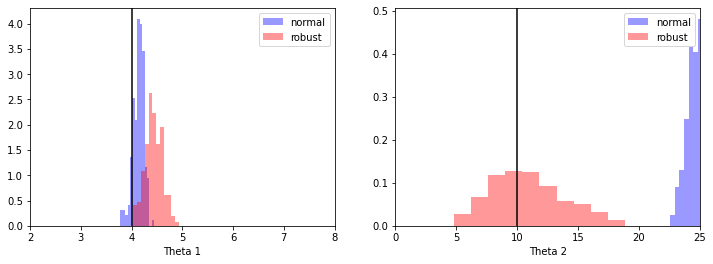

In [21]:
posterior_normal = np.load("../objects/ABC/ricker_final/degree=0.2/lambda=3/13/posterior_normal.npy")
posterior_robust = np.load("../objects/ABC/ricker_final/degree=0.2/lambda=3/7/posterior_robust.npy")

theta_gt = [4 ,10]
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.axvline(x=theta_gt[0],ls="-",c="black")
sns.distplot(posterior_normal[:, 0], color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(posterior_robust[:, 0], color='red', kde=False, norm_hist=True, label="robust")
plt.legend()
plt.xlim(2, 8)
plt.xlabel("Theta 1")

plt.subplot(1, 2, 2)
plt.axvline(x=theta_gt[1],ls="-",c="black")
sns.distplot(posterior_normal[:, 1], color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(posterior_robust[:, 1], color='red', kde=False, norm_hist=True, label="robust")
plt.legend()
plt.xlim(0, 25)
plt.xlabel("Theta 2")

plt.show()

In [22]:
rmse_abc = RMSE(torch.tensor([4, 10]), torch.tensor(posterior_normal), 2)
rmse_abc_rs = RMSE(torch.tensor([4, 10]), torch.tensor(posterior_robust), 2)

print(f"RMSE for ABC: {rmse_abc}")
print(f"RMSE for ABC-RS: {rmse_abc_rs}")

RMSE for ABC: 10.51747176346229
RMSE for ABC-RS: 2.241420489998796


In [191]:
n_sims = 50
beta = 5
rmse_normal = np.zeros(n_sims)
rmse_robust = np.zeros(n_sims)
for i in range(n_sims):
    root_name = f'../objects/ABC/ricker/lambda={beta}/' + str(i)
    posterior_normal = torch.tensor(np.load(root_name + '/posterior_normal.npy'))
    posterior_robust = torch.tensor(np.load(root_name + '/posterior_robust.npy'))
    rmse_normal[i] = RMSE(torch.tensor([4, 10]), posterior_normal, 2)
    rmse_robust[i] = RMSE(torch.tensor([4, 10]), posterior_robust, 2)

print("RMSE mean for normal model: ", np.mean(rmse_normal))
print("RMSE mean for robust model: ", np.mean(rmse_robust))
print("RMSE std for normal model: ", np.std(rmse_normal))
print("RMSE std for robust model: ", np.std(rmse_robust))

RMSE mean for normal model:  7.067988529761993
RMSE mean for robust model:  3.891314436146103
RMSE std for normal model:  0.3422907645779606
RMSE std for robust model:  1.1737282202563097
